In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

# Data
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

# Data
from glob import glob
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras import layers
# Image Size
IMG_WIDTH = 6900
IMG_HEIGHT = 160
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Batch Size
BATCH_SIZE = 16

# EPOCHS
EPOCHS = 100

# Model Name
MODEL_NAME = 'Handwritten-OCR_Malayalam-window'

# Callbacks
CALLBACKS = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath=MODEL_NAME + ".keras", save_best_only=True)
]

# Learning Rate
LEARNING_RATE = 1e-3

# Random Seed
np.random.seed(2569)
tf.random.set_seed(2569)

# File Paths
train_csv_path = "C://Users//Admin//Desktop//ML_codes//train_excel_sheet_window.xlsx"
test_csv_path =  "C://Users//Admin//Desktop//ML_codes//test_excel_sheet_window.xlsx"
valid_csv_path = "C://Users//Admin//Desktop//ML_codes//val_excel_sheet_window.xlsx"

train_image_dir = "C://Users//Admin//Desktop//ML_codes//train_window//train_window"
test_image_dir = "C://Users//Admin//Desktop//ML_codes//test_window//test_window"
valid_image_dir = "C://Users//Admin//Desktop//ML_codes//val_window//val_window"

# Data Size
TRAIN_SIZE = BATCH_SIZE * 10
VALID_SIZE = BATCH_SIZE * 5
TEST_SIZE  = BATCH_SIZE * 10

# AUTOTUNE
AUTOTUNE = tfd.AUTOTUNE


In [16]:
# Train CSV
train_csv = pd.read_excel(train_csv_path)[:TRAIN_SIZE]

# Validation CSV
valid_csv = pd.read_excel(valid_csv_path)[:VALID_SIZE]

# Test CSV
test_csv = pd.read_excel(test_csv_path)[:TEST_SIZE]

In [18]:
train_csv.head()

,gt,image name
0,തെ,MaI12_Page100_line_1.jpg_window_1.jpg
1,അ,MaI12_Page100_line_1.jpg_window_2.jpg
2,ത്ത,MaI12_Page100_line_1.jpg_window_3.jpg
3,താ,MaI12_Page100_line_1.jpg_window_4.jpg
4,ി,MaI12_Page100_line_1.jpg_window_5.jpg


In [20]:
train_labels = [str(word) for word in train_csv['gt'].to_numpy()]
train_labels[:10]

['തെ', 'അ', 'ത്ത', 'താ', 'ി', 'പ', 'രു', 'രള', 'ാളക', 'െ']

In [22]:
# Unique characters
unique_chars = set(char for word in train_labels for char in word)
n_classes = len(unique_chars)

# Show
print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 40
Unique Characters : 
{'ര', 'ആ', 'ങ', 'ധ', 'ച', 'ട', 'ദ', 'ഒ', 'ല', 'ജ', 'ഠ', 'വ', '്', 'ഷ', 'അ', 'ാ', 'ന', 'ത', 'മ', 'ൂ', 'ർ', 'ണ', 'ി', 'ു', 'പ', 'ക', 'ള', 'ം', '"', 'ഹ', 'െ', 'ൽ', 'യ', 'ഗ', 'ഇ', 'റ', 'ഴ', 'ഫ', 'ഉ', 'എ'}


In [24]:
MAX_LABEL_LENGTH = max(map(len, train_labels))
print(f"Maximum length of a label : {MAX_LABEL_LENGTH}")

Maximum length of a label : 6


In [26]:
train_csv['image name'] = [train_image_dir + f"/{filename}" for filename in train_csv['image name']]
valid_csv['image name'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['image name']]
test_csv['image name']  = [test_image_dir + f"/{filename}" for filename in test_csv['image name']]

In [28]:
train_csv.head()

,gt,image name
0,തെ,C://Users//Admin//Desktop//ML_codes//train_win...
1,അ,C://Users//Admin//Desktop//ML_codes//train_win...
2,ത്ത,C://Users//Admin//Desktop//ML_codes//train_win...
3,താ,C://Users//Admin//Desktop//ML_codes//train_win...
4,ി,C://Users//Admin//Desktop//ML_codes//train_win...


In [30]:
# Character to numeric value dictionary
char_to_num = layers.StringLookup(
    vocabulary = list(unique_chars),
    mask_token = None
)

# Reverse dictionary
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None, 
    invert = True
)

In [32]:
def load_image(image_path : str):
    '''
    This function loads and preprocesses images. It first receives the image path, which is used to
    decode the image as a JPEG using TensorFlow. Then, it converts the image to a tensor and applies 
    two processing functions: resizing and normalization. The processed image is then returned by 
    the function.
    
    Argument : 
        image_path : The path of the image file to be loaded.
    
    Return:
        image : The loaded image as a tensor.
    '''
    
    # Read the Image
    image = tf.io.read_file(image_path)
    
    # Decode the image
    decoded_image = tf.image.decode_jpeg(contents = image, channels = 1)
    
    # Convert image data type.
    cnvt_image = tf.image.convert_image_dtype(image = decoded_image, dtype = tf.float32)
    
    # Resize the image
    resized_image = tf.image.resize(images = cnvt_image, size = (IMG_HEIGHT, IMG_WIDTH))
    
    # Transpose
    image = tf.transpose(resized_image, perm = [1, 0, 2])
    
    # Convert image to a tensor.
    image = tf.cast(image, dtype = tf.float32)
    
    # Return loaded image
    return image

In [34]:
def encode_single_sample(image_path : str, label : str):
    
    '''
    The function takes an image path and label as input and returns a dictionary containing the processed image tensor and the label tensor. 
    First, it loads the image using the load_image function, which decodes and resizes the image to a specific size. Then it converts the given
    label string into a sequence of Unicode characters using the unicode_split function. Next, it uses the char_to_num layer to convert each
    character in the label to a numerical representation. It pads the numerical representation with a special class (n_classes)
    to ensure that all labels have the same length (MAX_LABEL_LENGTH). Finally, it returns a dictionary containing the processed image tensor
    and the label tensor.
    
    Arguments : 
        image_path : The location of the image file.
        label      : The text to present in the image.
    
    Returns:
        dict : A dictionary containing the processed image and label.
    '''
    
    # Get the image
    image = load_image(image_path)
    
    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    print(chars)
    # Convert the characters into vectors
    vecs = char_to_num(chars)
   
    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)
    
    return {'image':image, 'label':vecs}

In [38]:
def encode_single_sample(image_path: str, label: str):
    
    # Get the image
    image = load_image(image_path)
    
    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    
    # Convert the characters into vectors
    vecs = char_to_num(chars)
    
    # Calculate current length of vecs
    current_vecs_length = tf.shape(vecs)[0]
    pad_size = MAX_LABEL_LENGTH - current_vecs_length

    # Print current lengths for debugging (optional)
    tf.print("Current vecs length:", current_vecs_length)
    tf.print("Pad size:", pad_size)

    # Only pad if pad_size is positive
    if pad_size > 0:
        vecs = tf.pad(vecs, paddings=[[0, pad_size]], constant_values=n_classes + 1)
    elif pad_size < 0:
        # If pad_size is negative, truncate the vecs to MAX_LABEL_LENGTH
        vecs = vecs[:MAX_LABEL_LENGTH]
        pad_size = 0  # Set pad_size to 0 since we've truncated

    return {'image': image, 'label': vecs}

In [42]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['image name'].to_list()), np.array(train_csv['gt'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['image name'].to_list()), np.array(valid_csv['gt'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['image name'].to_list()), np.array(test_csv['gt'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [44]:
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 160
Validation Data Size : 80
Testing Data Size    : 160


In [46]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID
    
    # Loading Data 
    data = next(iter(data))
    images, labels = data['image'], data['label']
    
    # Iterate over the data 
    for index, (image, label) in enumerate(zip(images, labels)):
        
        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()
        
        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')
        
        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3363 (\N{MALAYALAM LETTER NNA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Malayalam natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3349 (\N{MALAYALAM LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3390 (\N{MALAYALAM VOWEL SIGN AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3374 (\N{MALAYALAM LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\Lib\si

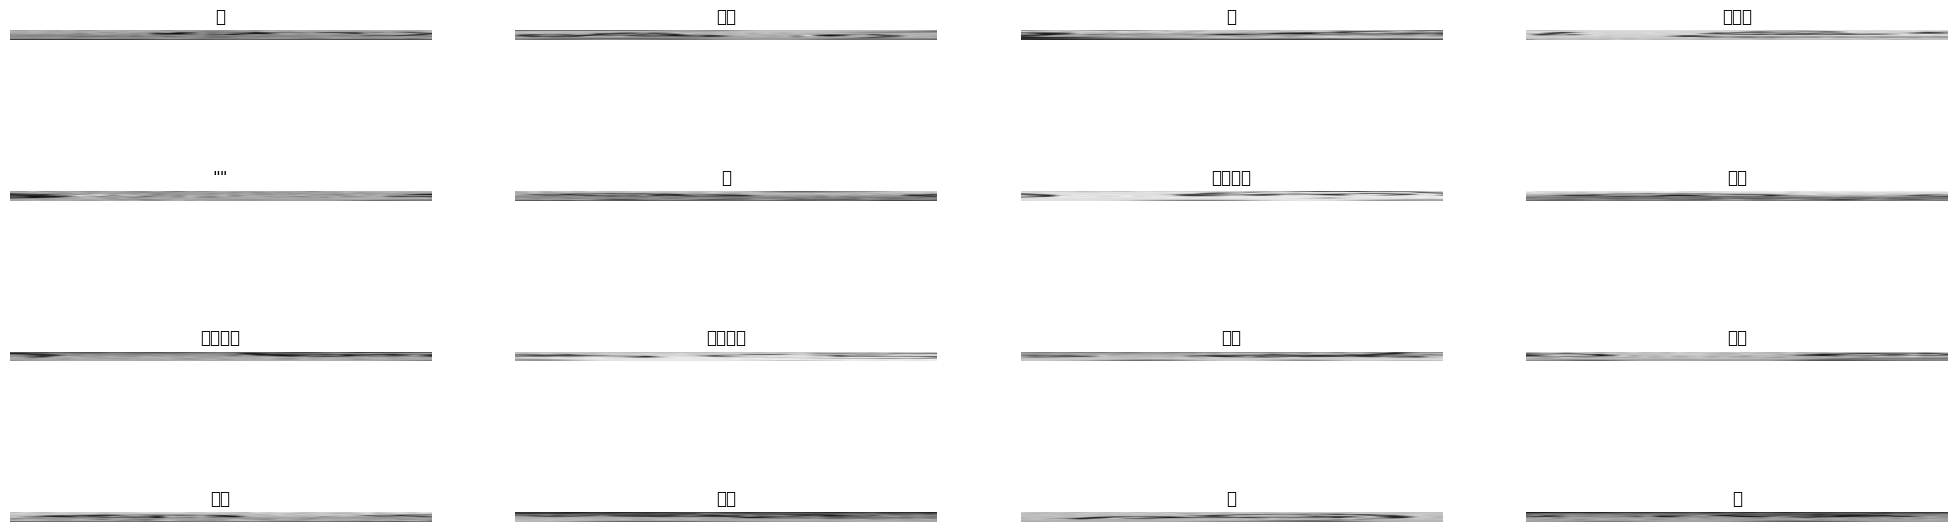

In [48]:
show_images(data=train_ds, cmap='gray')

In [50]:
class CTCLayer(layers.Layer):
    
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        
        self.loss_fn = keras.backend.ctc_batch_cost
    
    def call(self, y_true, y_pred):
        
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        
        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        
        loss = self.loss_fn(y_true, y_pred, input_len, label_len)
        
        self.add_loss(loss)
        
        return y_pred
    

In [52]:
# Input Layer
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
target_labels = layers.Input(shape=(None, ), name="label")
print(input_images.shape)
# CNN Network
x = layers.Conv2D(
    filters=32, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Encoding Space
encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*64))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.2)(encoding)

# RNN Network
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

# Output Layer
output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)

# CTC Layer
ctc_layer = CTCLayer()(target_labels, output)

# Model 
ocr_model = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

(None, 6900, 160, 1)




In [54]:
ocr_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, 6900, 160, 1)      │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 6900, 160, 32)     │             320 │ image[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 3450, 80, 32)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 3450, 80, 64)      │          18,496 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 1725, 40, 64)      │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1725, 2560)        │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1725, 64)          │         163,904 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 1725, 64)          │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 1725, 256)         │         197,632 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_1               │ (None, 1725, 128)         │         164,352 │ bidirectional[0][0]        │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ label (InputLayer)            │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1725, 42)          │           5,418 │ bidirectional_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ctc_layer (CTCLayer)          │ (None, 1725, 42)          │               0 │ label[0][0], dense_1[0][0] │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 550,122 (2.10 MB)

 Trainable params: 550,122 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
tf.keras.utils.plot_model(ocr_model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
# Compile
ocr_model.compile(optimizer='adam')

# Train
history = ocr_model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=EPOCHS,
    callbacks=CALLBACKS
)

Epoch 1/100


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image', 'label']. Received: the structure of inputs={'image': '*', 'label': '*'}
  warnings.warn(


Current vecs length: 5
Current vecs length: 2
Current vecs length: 4
Current vecs length: 2
Current vecs length: 2
Pad size: 4
Pad size: 2
Pad size: 4
Current vecs length: 2
Current vecs length: 2
Pad size: 4
Current vecs length: 2
Pad size: 1
Pad size: 4
Current vecs length: 2
Current vecs length: 4
Pad size: 4
Current vecs length: 3
Current vecs length: 2
Pad size: 4
Current vecs length: 2
Pad size: 4
Pad size: 4
Pad size: 3
Pad size: 2
Pad size: 4
Current vecs length: 2
Current vecs length: 2
Pad size: 4
Current vecs length: 1
Current vecs length: 2
Current vecs length: 1
Current vecs length: 3
Current vecs length: 1
Current vecs length: 4
Current vecs length: 2
Pad size: 5
Pad size: 4
Pad size: 5
Pad size: 5
Pad size: 4
Pad size: 2
Pad size: 4
Pad size: 3
Current vecs length: 5
Current vecs length: 4
Current vecs length: 1
Current vecs length: 2
Pad size: 1
Current vecs length: 1
Current vecs length: 2
Current vecs length: 3
Current vecs length: 1
Pad size: 2
Pad size: 5
Pad size: 

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Learning Curve", fontsize=15)
plt.grid()
plt.savefig("OCRModel-LearningCurve.png")
plt.show()

In [3]:
# Model required for inference
inference_model = keras.Model(
    inputs=ocr_model.get_layer(name="image").input,
    outputs=ocr_model.get_layer(name='dense').output
)

# Model summary
inference_model.summary()

NameError: name 'keras' is not defined

In [ ]:
def decode_pred(pred_label):
    
    '''
    The decode_pred function is used to decode the predicted labels generated by the OCR model.
    It takes a matrix of predicted labels as input, where each time step represents the probability 
    for each character. The function uses CTC decoding to decode the numeric labels back into their 
    character values. The function also removes any unknown tokens and returns the decoded texts as a
    list of strings. The function utilizes the num_to_char function to map numeric values back to their
    corresponding characters. Overall, the function is an essential step in the OCR process, as it allows
    us to obtain the final text output from the model's predictions.
    
    Argument : 
        pred_label : These are the model predictions which are needed to be decoded.
        
    Return:
        filtered_text : This is the list of all the decoded and processed predictions.
    
    '''
    
    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]
    
    # CTC decode
    decode = keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]
    
    # Converting numerics back to their character values
    chars = num_to_char(decode)
    
    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    
    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]
    
    return filtered_texts


In [ ]:
print(decode_pred(inference_model.predict(test_ds)))

In [ ]:
print(decode_pred(inference_model.predict(train_ds)))

In [ ]:
show_images(data=test_ds, model=inference_model, decode_pred=decode_pred, cmap='binary')

In [ ]:
# Save the entire model
ocr_model.save('hcr_ocr_encoder_decoder_mal.h5')

In [ ]:
#Input Layer
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
target_labels = layers.Input(shape=(None, ), name="label")

# CNN Network
x = layers.Conv2D(
    filters=32, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(input_images)

x = layers.Conv2D(
    filters=32, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = layers.Conv2D(
    filters=64, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.Conv2D(
    filters=128, 
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal'
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

# Encoding Space
encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*128))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.4)(encoding)

# RNN Network
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

# Output Layer
output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax')(x)

# CTC Layer
ctc_layer = CTCLayer()(target_labels, output)

# Model 
ocr_model_2 = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)

# Compile
ocr_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

# Train
history_2 = ocr_model_2.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=EPOCHS,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# Learning Curve
pd.DataFrame(history_2.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Learning Curve", fontsize=15)
plt.grid()
# plt.savefig("OCRModel-LearningCurve.png")
plt.show()

In [ ]:
# Model required for inference
inference_model_2 = keras.Model(
    inputs=ocr_model_2.get_layer(name="image").input,
    outputs=ocr_model_2.get_layer(name='dense_4').output
)

# Model summary
inference_model_2.summary()

In [ ]:
show_images(data=test_ds, model=inference_model_2, decode_pred=decode_pred, cmap='binary')

In [ ]:
show_images(data=valid_ds, model=inference_model_2, decode_pred=decode_pred, cmap='binary')

In [ ]:
import os
import matplotlib.pyplot as plt

def show_and_save_images(data, model, decode_pred, save_folder='output_images', cmap='binary'):
    # Create the folder if it doesn't exist
    os.makedirs(save_folder, exist_ok=True)

    for i, batch in enumerate(data):
        # Check if the batch is a dictionary
        if isinstance(batch, dict):
            images = batch['image']  # Adjust this key to match your dataset
            labels = batch['label']  # Adjust this key as needed
        else:
            raise ValueError(f"Expected batch to be a dictionary, but got {type(batch)}")

        # If the dataset provides batches, loop through each image in the batch
        for j, image in enumerate(images):
            # Perform inference and get the prediction
            pred = model.predict(image[None, ...])  # Add batch dimension if needed
            decoded_pred = decode_pred(pred)

            # Plot the image
            plt.figure(figsize=(5, 5))
            plt.imshow(image, cmap=cmap)
            plt.title(f'Prediction: {decoded_pred}')
            plt.axis('off')

            # Save the image
            save_path = os.path.join(save_folder, f'image_{i}_{j}.png')
            plt.savefig(save_path, bbox_inches='tight')
            plt.close()  # Close the plot to free memory

    print(f"Images saved to folder: {save_folder}")

In [ ]:
show_and_save_images(valid_ds, inference_model_2, decode_pred)
